In [70]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
start_token = "."
end_token = "."
words = open("./data/names.txt", "r").read().splitlines()

In [54]:
chars = list(set(start_token + end_token)) + sorted(list(set("".join(words))))
char_to_idx = {char: index for index, char in enumerate(chars)}
idx_to_char = {index: char for index, char in enumerate(chars)}

len(chars)

27

In [55]:
N = torch.zeros((len(chars), len(chars)), dtype=torch.int32)
N.shape

torch.Size([27, 27])

## Counts Array

In [56]:
bigram_counts = {}
for word in words:
    word_w_tokens = [start_token] + list(word) + [end_token]
    for c1, c2 in zip(word_w_tokens, word_w_tokens[1:]):
        N[char_to_idx.get(c1), char_to_idx.get(c2)] += 1

In [ ]:
# N = N + 1 # smoothing
P = (N+1) / (N+1).sum(dim=1, keepdim=True)
P.sum(dim=1) # check to see if broadcasting done properly

(-0.5, 26.5, 26.5, -0.5)

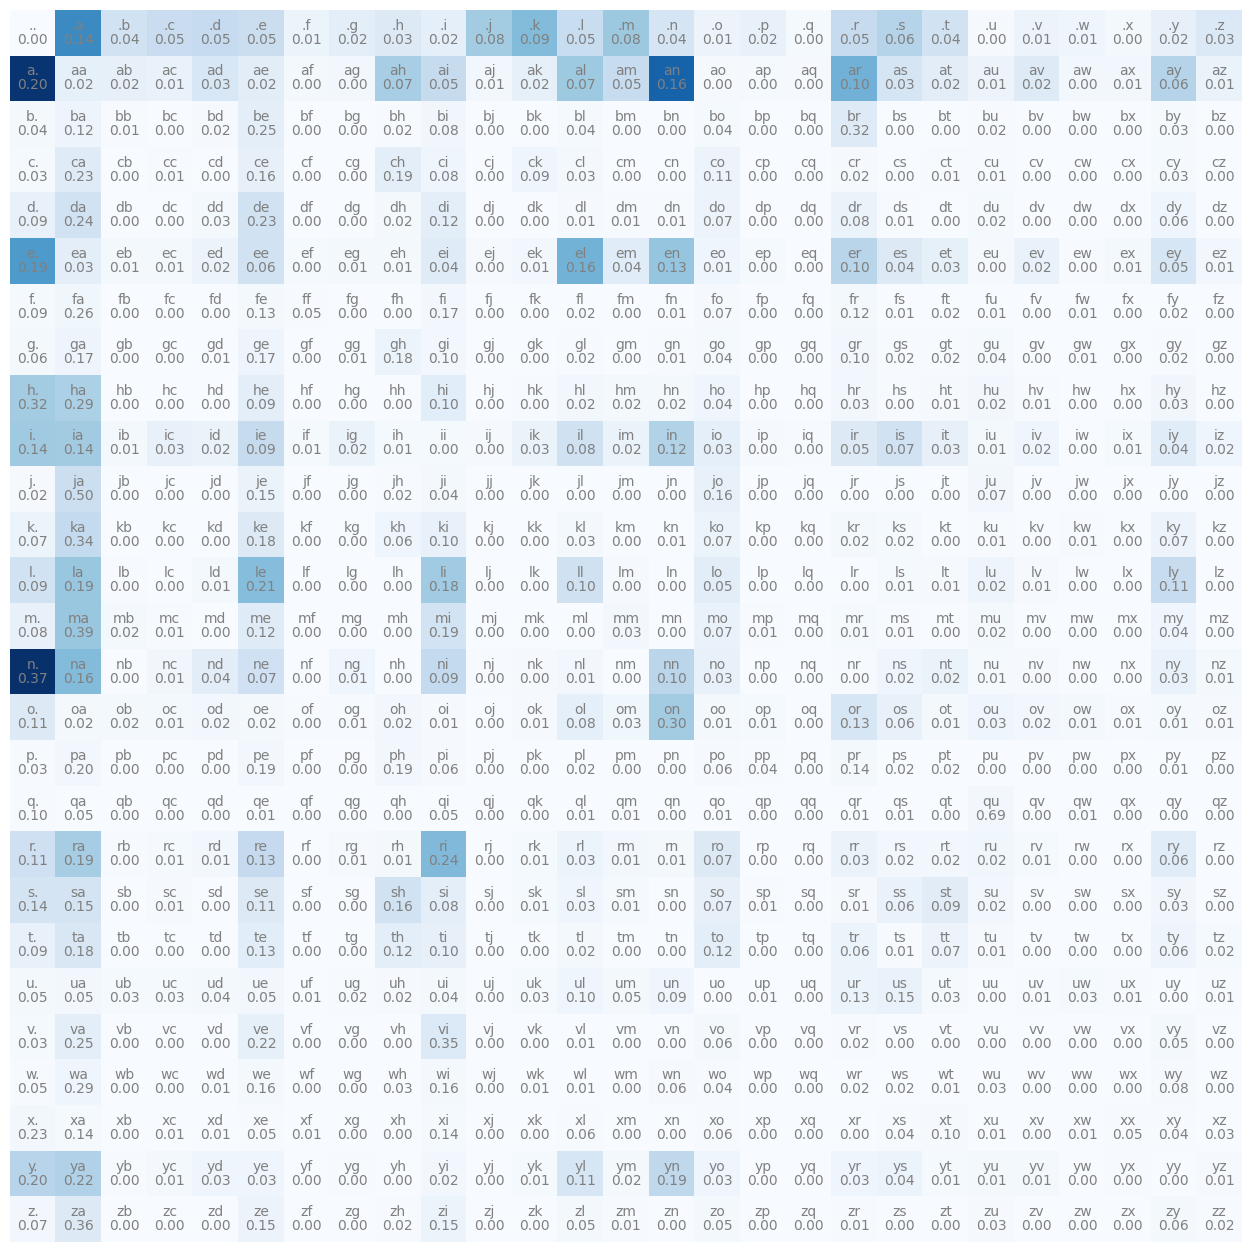

In [319]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Blues")
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, f"{P[i, j].item():.2f}", ha="center", va="top", color='gray')
plt.axis('off')

## Probs Array

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

## Sampling from Model

In [59]:
# sampling
g = torch.Generator().manual_seed(16)
for _ in range(3):
    samples = ["."]
    while True:
        last_sample = samples[-1]
        last_sample_idx = char_to_idx[last_sample]
        relevant_probs = P[last_sample_idx]
        uniform_probs = torch.ones(len(chars)) / len(chars) # for baseline testing
        
        sampled_idx = torch.multinomial(relevant_probs, 1, True, generator=g).data.item()
        sampled_char = idx_to_char[sampled_idx]
        samples.append(sampled_char)
        
        if sampled_char == end_token:
            break

    print("".join(samples))

.elyleryapannxth.
.ma.
.mitoraluveliami.


## Evaluating Model

In [272]:
# evaluating this bigram model
# maximum likelihood
# likelihood: multiply together probabilities

log_probs = []
for word in words:
    word = start_token + word + end_token
    for (c1, c2) in zip(word, word[1:]):
        idx1 = char_to_idx[c1]
        idx2 = char_to_idx[c2]
        
        prob = P[idx1, idx2]
        log_prob = prob.log()
        # print(prob, lo)
        log_probs.append(log_prob)
        
        # print(f"{c1}{c2}: {prob:.4f} {log_prob:.4f}")

log_likelihood = torch.tensor(log_probs).sum()
nlog_likelihood = log_likelihood * -1

print(f"{log_likelihood=}")
print(f"{nlog_likelihood=}")
print(nlog_likelihood / len(log_probs))
        

log_likelihood=tensor(-560001.8750)
nlog_likelihood=tensor(560001.8750)
tensor(2.4546)


## Gradient Approach

In [230]:
# doing the same, but now workign with torch tensors instead of other intermediary shit
xs = []
ys = []
for word in words:
    word = start_token + word + end_token
    for (c1, c2) in zip(word, word[1:]):
        idx1 = char_to_idx[c1]; idx2 = char_to_idx[c2]
        xs.append(idx1)
        ys.append(idx2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs.shape, ys.shape)

xenc: torch.Tensor = F.one_hot(xs, num_classes=len(chars)).float()
print(xenc.shape)

torch.Size([228146]) torch.Size([228146])
torch.Size([228146, 27])


In [231]:
# model initialization
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(chars), len(chars)), requires_grad=True, generator=g)

In [304]:
for iteration in range(100):
    # forward pass
    logits = xenc @ W # interpreting as log(counts) [logits] [negative & positive range]
    counts = logits.exp() # counts
    probs = counts / counts.sum(dim=1, keepdim=True) # prob distribs
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    loss
    
    print(f"{iteration:03d}: {loss=}")

    # backward pass
    W.grad = None # flushing gradients
    loss.backward()

    # update
    W.data += -50 * W.grad
    
    

000: loss=tensor(2.4591, grad_fn=<NegBackward0>)
001: loss=tensor(2.4591, grad_fn=<NegBackward0>)
002: loss=tensor(2.4591, grad_fn=<NegBackward0>)
003: loss=tensor(2.4591, grad_fn=<NegBackward0>)
004: loss=tensor(2.4590, grad_fn=<NegBackward0>)
005: loss=tensor(2.4590, grad_fn=<NegBackward0>)
006: loss=tensor(2.4590, grad_fn=<NegBackward0>)
007: loss=tensor(2.4590, grad_fn=<NegBackward0>)
008: loss=tensor(2.4590, grad_fn=<NegBackward0>)
009: loss=tensor(2.4590, grad_fn=<NegBackward0>)
010: loss=tensor(2.4589, grad_fn=<NegBackward0>)
011: loss=tensor(2.4589, grad_fn=<NegBackward0>)
012: loss=tensor(2.4589, grad_fn=<NegBackward0>)
013: loss=tensor(2.4589, grad_fn=<NegBackward0>)
014: loss=tensor(2.4589, grad_fn=<NegBackward0>)
015: loss=tensor(2.4589, grad_fn=<NegBackward0>)
016: loss=tensor(2.4588, grad_fn=<NegBackward0>)
017: loss=tensor(2.4588, grad_fn=<NegBackward0>)
018: loss=tensor(2.4588, grad_fn=<NegBackward0>)
019: loss=tensor(2.4588, grad_fn=<NegBackward0>)
020: loss=tensor(2.4

In [307]:
# all xenc is doing is plucking out rows
counts = W.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs

tensor([[3.3045e-04, 1.3766e-01, 4.0758e-02, 4.8125e-02, 5.2746e-02, 4.7782e-02,
         1.3005e-02, 2.0872e-02, 2.7272e-02, 1.8437e-02, 7.5597e-02, 9.2486e-02,
         4.9062e-02, 7.9218e-02, 3.5763e-02, 1.2287e-02, 1.6065e-02, 2.8575e-03,
         5.1153e-02, 6.4140e-02, 4.0820e-02, 2.4215e-03, 1.1725e-02, 9.5710e-03,
         4.1695e-03, 1.6689e-02, 2.8989e-02],
        [1.9596e-01, 1.6408e-02, 1.5966e-02, 1.3870e-02, 3.0751e-02, 2.0422e-02,
         3.9541e-03, 4.9576e-03, 6.8821e-02, 4.8694e-02, 5.1642e-03, 1.6762e-02,
         7.4605e-02, 4.8222e-02, 1.6048e-01, 1.8625e-03, 2.4201e-03, 1.7736e-03,
         9.6326e-02, 3.2994e-02, 2.0274e-02, 1.1244e-02, 2.4612e-02, 4.7510e-03,
         5.3708e-03, 6.0499e-02, 1.2837e-02],
        [4.1103e-02, 1.1951e-01, 1.2057e-02, 2.3910e-03, 2.1978e-02, 2.4582e-01,
         2.1066e-03, 1.9256e-03, 1.2084e-02, 8.0163e-02, 2.5491e-03, 1.5029e-03,
         3.6917e-02, 2.6151e-03, 1.9966e-03, 3.7674e-02, 2.3063e-03, 2.5348e-03,
         3.1653e-

(-0.5, 26.5, 26.5, -0.5)

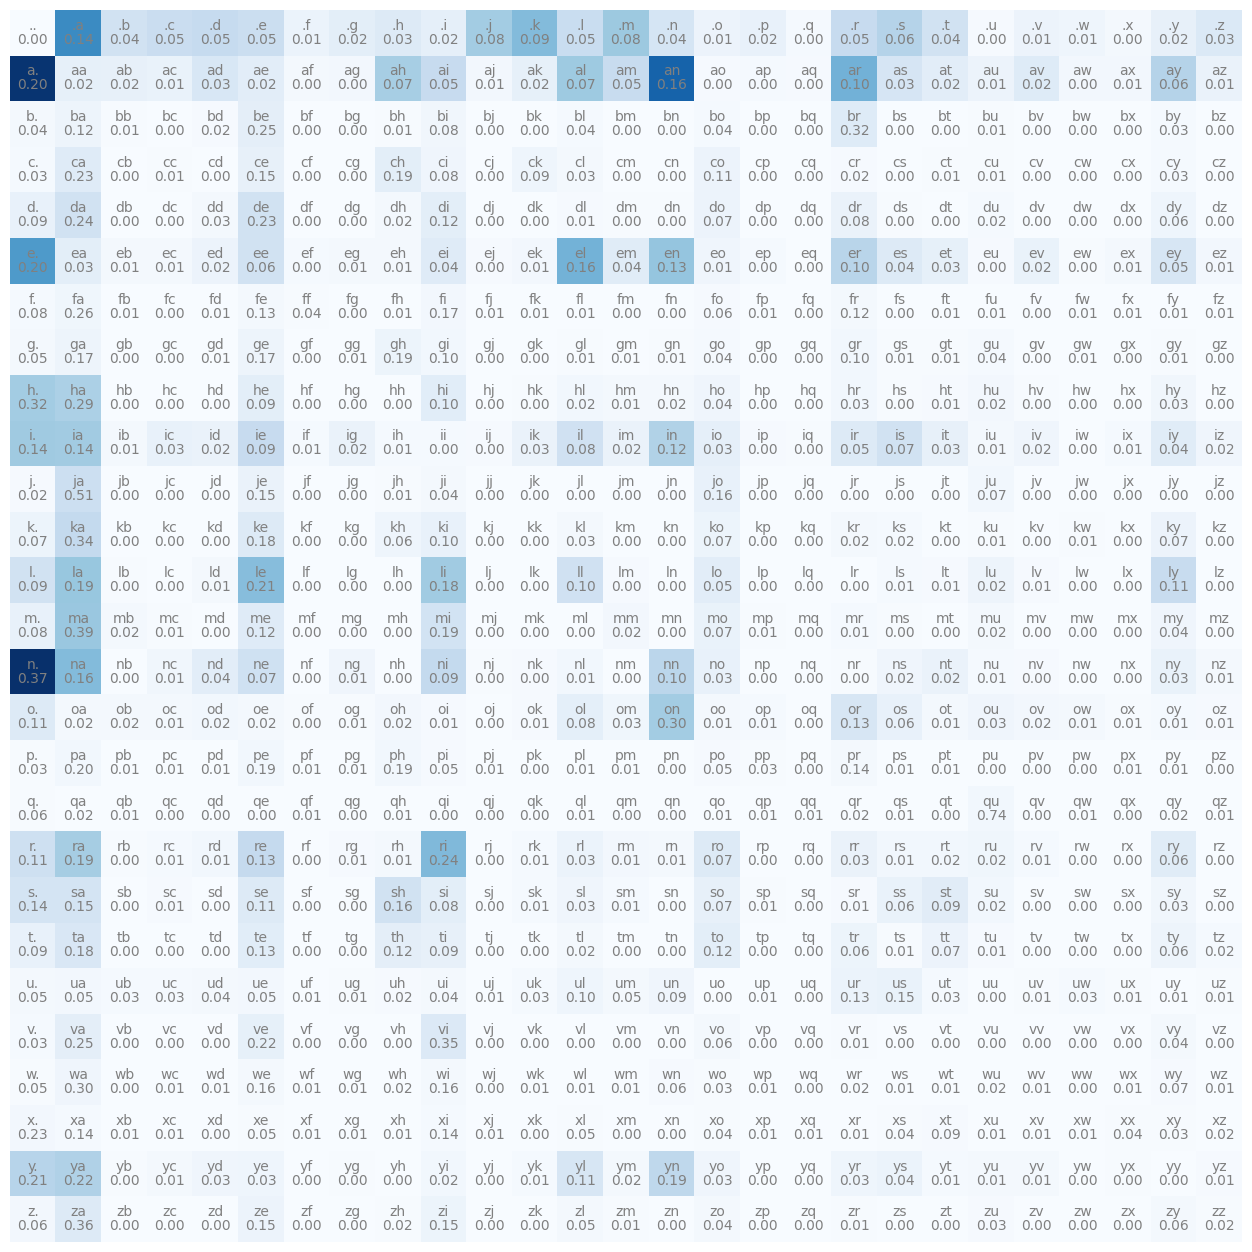

In [315]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, f"{probs[i, j].item():.2f}", ha="center", va="top", color='gray')
plt.axis('off')